# Earnings or environment
### An exploration of the relationship between wellbeing, access to nature and earnings across London's boroughs
##### Huw Hallam

<br>In this workbook, I explore and visualise the relationship between wellbeing, greenspace and earnings across different parts of London. I ask:
- Is there a link, for Londoners, between wellbeing and access to nature?
- Does being a high earner feature in the relationship between these variables?

I draw on two datasets, from the Office of National Statistics (ONS), which record various wellbeing and wealth metrics across each of London's boroughs. I link these with Ordnance Survey data charting the extent of green and blue spaces - the city’s parks, gardens, trees, green spaces, rivers and wetlands, and features such as green roofs.

My analysis points to a reasonably high correlation between green space and wellbeing, a relationship supported by much recent mental health research (see, for example: https://www.rcpsych.ac.uk/news-and-features/blogs/detail/sustainability-blog/2024/03/06/nature-matters-in-mental-health). I wanted to test how robust this relationship was in the case of London, wondering if other factors - specifically, income - might be behind the apparent relationship between wellbeing and greenspace density. Could it be that wealth allowed greater access to greenspace and also contributed to wellbeing, as such, functioning as a confounding variable? My analysis suggests the opposite: though there are doubtless many factors that contribute to wellbeing beyond access to nature, high earning correlates more closely with anxiety than with wellbeing and also has an inverse relationship with green- and bluespace density.

#### Source data
##### Personal Wellbeing by Borough
Estimates of personal well-being from the Annual Population Survey (APS) Well-being dataset. The data covers four different areas of wellbeing: life satisfaction, how worthwhile people feel, happiness and anxiety. Survey respondents were asked to respond with a score from 1-10 to questions such as, 'How satisfied are you with your life nowadays?' and 'To what extent do you feel the things you do in your life are worthwhile?'. The dataset provides median scores for each borough as well as the percentage of respondants in each borough that fell into four response bands, from low to very high. The survey was repeated yearly from 2011-19.

https://data.london.gov.uk/dataset/subjective-personal-well-being-borough

##### Earnings by Place of Residence, Borough
Gross earnings per person by place of residence (based on HMRC PAYE records; excludes self-employed and unemployed individuals). From the Annual Survey of Hours and Earnings (ASHE), ONS.

https://data.london.gov.uk/dataset/earnings-place-residence-borough

##### London Green and Blue Cover
Dataset produced by the Greater London Authority (GLA) in 2019. The green cover layer was created by combining classified near-infrared aerial imagery (NDVI) with land use datasets.

https://data.london.gov.uk/dataset/green-and-blue-cover

##### Statistical Boundary File
This analysis uses a London borough map file provided by ONS/GLA

https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london



<br>© Huw Hallam, 2025
<br><i>Contains National Statistics and Ordnance Survey data. © Crown copyright and database right [2015, 2019]</i>

In [2]:
import pandas as pd
import geopandas as gdp
import matplotlib.pyplot as plt

In [3]:
# Load personal wellbeing datasets

# Source: https://data.london.gov.uk/dataset/subjective-personal-well-being-borough

life_satisfaction = pd.read_excel('personal-well-being-borough.xlsx', sheet_name='Summary - Mean Scores', header=1, index_col=0, usecols='B:J', skiprows=[2,3])[:32]
worthwhile = pd.read_excel('personal-well-being-borough.xlsx', sheet_name='Summary - Mean Scores', header=1, index_col=0, usecols='B, L:S', skiprows=[2,3])[:32]
worthwhile.columns = life_satisfaction.columns
happiness = pd.read_excel('personal-well-being-borough.xlsx', sheet_name='Summary - Mean Scores', header=1, index_col=0, usecols='B, U:AB', skiprows=[2,3])[:32]
happiness.columns = life_satisfaction.columns
anxiety = pd.read_excel('personal-well-being-borough.xlsx', sheet_name='Summary - Mean Scores', header=1, index_col=0, usecols='B, AD:AK', skiprows=[2,3])[:32]
anxiety.columns = life_satisfaction.columns
#anxiety.head()

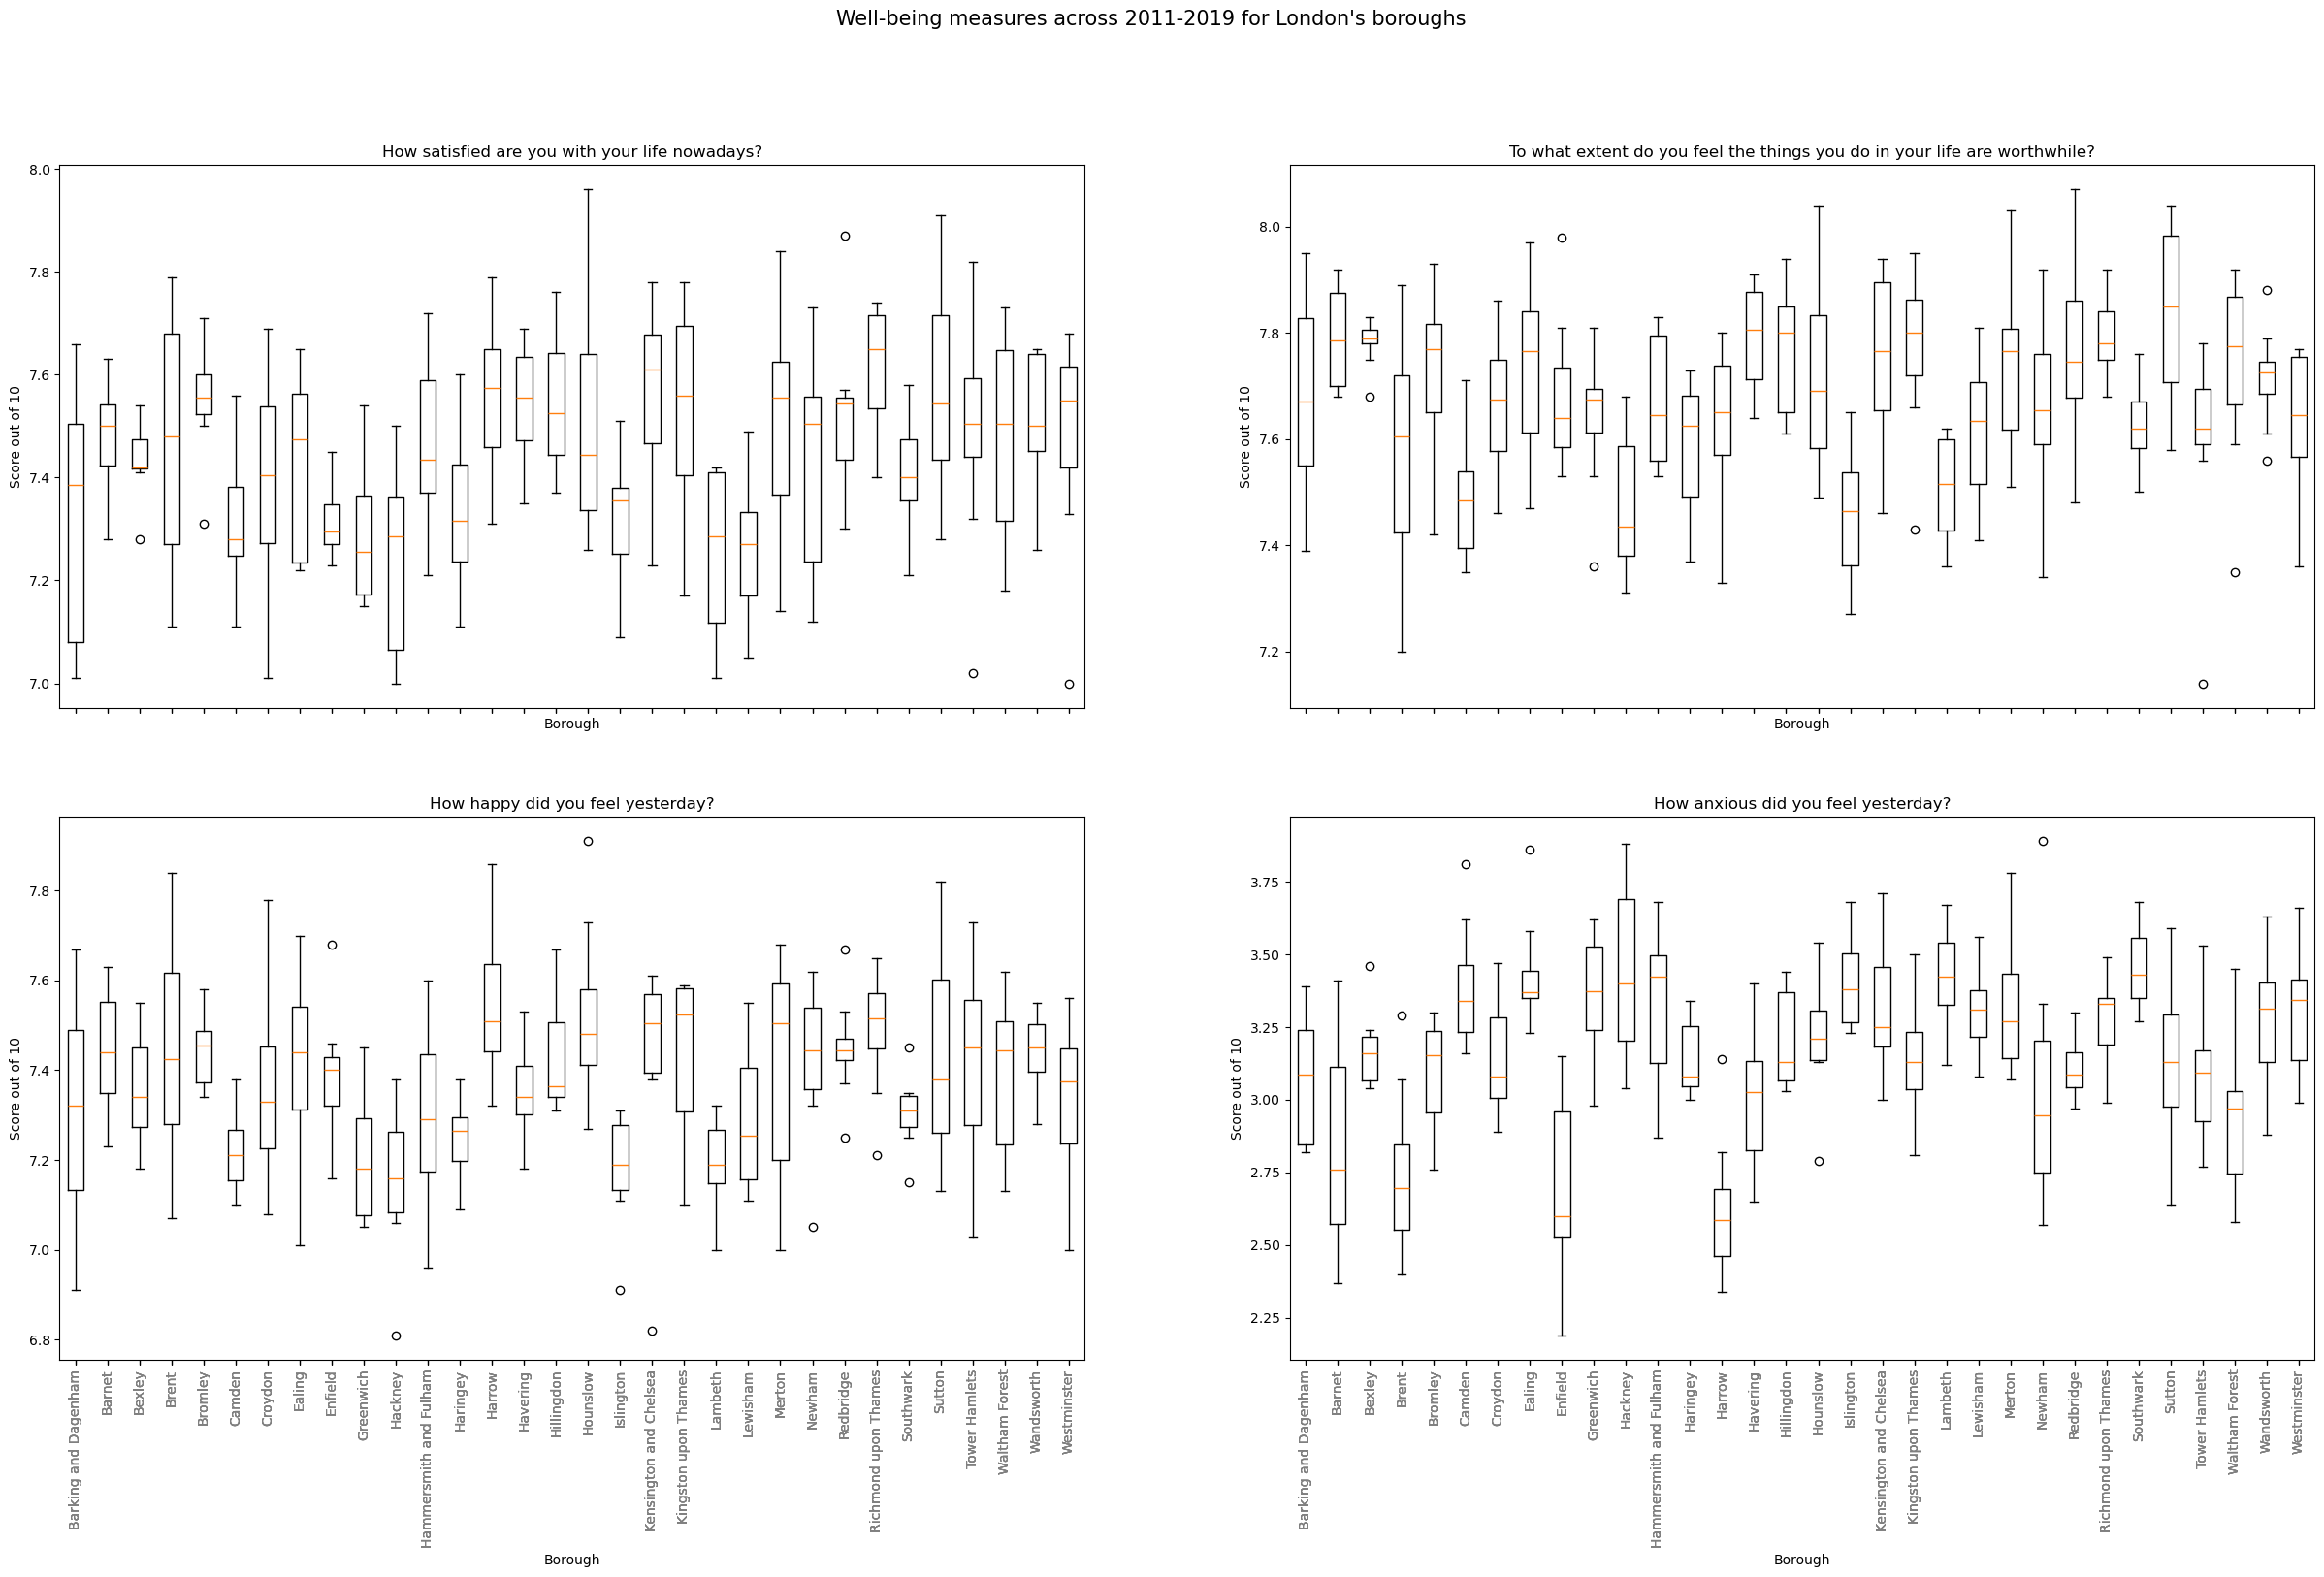

In [4]:
# Plot the spread of mean score responses across all survey years for life satisfaction, worthwhileness, happiness and anxiety

fig,axs=plt.subplots(2,2,figsize=(30,16), sharex=True)
fig.suptitle("Well-being measures across 2011-2019 for London's boroughs", fontsize=15)#, loc='left')

axs[0, 0].boxplot(life_satisfaction.T, notch=False, tick_labels=anxiety.index)
axs[0, 0].set_title('How satisfied are you with your life nowadays?')

axs[0, 1].boxplot(worthwhile.T, notch=False, tick_labels=anxiety.index)
axs[0, 1].set_title('To what extent do you feel the things you do in your life are worthwhile?')
axs[1, 0].boxplot(happiness.T, notch=False, tick_labels=anxiety.index)
axs[1, 0].set_title('How happy did you feel yesterday?')
axs[1,0].tick_params(axis='x', labelrotation=90, labelcolor='grey')
axs[1, 1].boxplot(anxiety.T, notch=False, tick_labels=anxiety.index)
axs[1, 1].set_title('How anxious did you feel yesterday?')
axs[1,1].tick_params(axis='x', labelrotation=90, labelcolor='grey');

for ax in axs.flat:
    ax.set(xlabel='Borough', ylabel='Score out of 10')


In [5]:
#Create datasets with the % of each borough that falls into the highest band for worthwhileness and both the highest and lowest for anxiety

vh_worthwhile = pd.read_excel('personal-well-being-borough.xlsx', sheet_name='Worthwhile', index_col=0, usecols='B,F,K,P,U,Z,AE,AJ,AO', skiprows=[1,2,3])[:32]
vh_anxiety = pd.read_excel('personal-well-being-borough.xlsx', sheet_name='Anxiety', index_col=0, usecols='B,F,K,P,U,Z,AE,AJ,AO', skiprows=[1,2,3])[:32]
l_anxiety = pd.read_excel('personal-well-being-borough.xlsx', sheet_name='Anxiety', index_col=0, usecols='B,C,H,M,R,W,AB,AG,AL', skiprows=[1,2,3])[:32]

In [6]:
# Load Green and Blue Cover data

# https://data.london.gov.uk/dataset/green-and-blue-cover
# Contains OS data © Crown copyright and database rights 2019. 

green = pd.read_excel('green_cover_borough_summary_0.05.xlsx', sheet_name='borough_green_cover', index_col=0, usecols='A,C:I')
green.rename(index={'City of Westminster':'Westminster'},inplace=True)
#green.head()

In [7]:
# Load Earnings data
# https://data.london.gov.uk/dataset/earnings-place-residence-borough

earnings = pd.read_excel('earnings-residence-borough.xlsx', sheet_name='Total, weekly', index_col=0, usecols='B,W,Y,AA,AC,AE,AG,AI,AK', skiprows=[1,2,3])[:32]
#earnings.head()

In [8]:
# Load London borough boundary map data

#https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

map_df=gdp.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
#map_df.head()

In [9]:
# Merge boundary map with greenspace data

merged=map_df.set_index('NAME').join(green)
#merged.head()

In [10]:
# Calculate mean well-being scores across 2011-2019 and add to merged dataset
merged['life_satisfaction'] = life_satisfaction.mean(axis=1)
merged['worthwhile'] = worthwhile.mean(axis=1)
merged['vh_worthwhile'] = vh_worthwhile.mean(axis=1)
merged['happiness'] = happiness.mean(axis=1)
merged['anxiety'] = anxiety.mean(axis=1)
merged['vh_anxiety'] = vh_anxiety.mean(axis=1)
merged['l_anxiety'] = l_anxiety.mean(axis=1)
merged['weekly_earnings'] = earnings.mean(axis=1)
#merged.head()

In [11]:
# This function facilitates exploration, allowing a given metric to be mapped onto the statistical boundary map

def borough_plot(target, cmap, title):
    vmin,vmax=merged[target].min(),merged[target].max()
    fig,ax=plt.subplots(1,figsize=(6, 4))
    merged.plot(column=target,cmap=cmap,ax=ax)
    ax.axis('off')
    plt.title(title,{'fontsize': '12', 'fontweight' :'100'})
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax=ax.inset_axes([0.97, 0.1, 0.03, 0.8])).outline.set_visible(False)

It can be interesting to explore different ways of looking at the wellbeing metrics. The following two charts visualise scores in response to the question, 'To what extent do you feel the things you do in your life are worthwhile?'. The first uses the median of the score out of ten, averaged across the time period. The second shows the % of the borough that falls into the highest response band. There is a small degree of variation between the two plots.

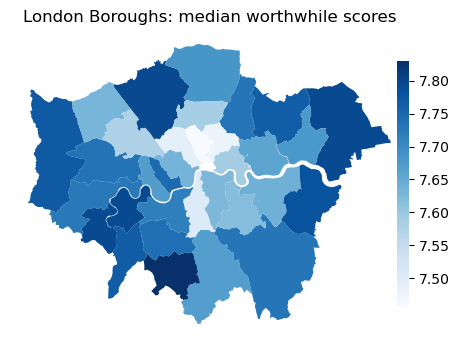

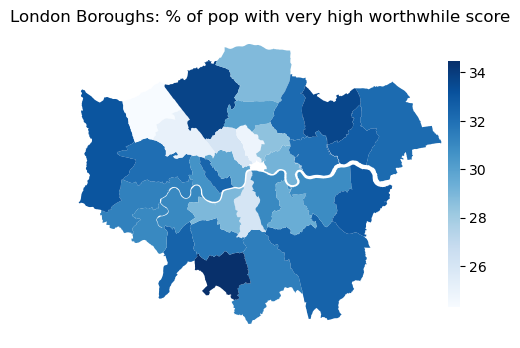

In [13]:
borough_plot(target='worthwhile', cmap='Blues', title='London Boroughs: median worthwhile scores')
borough_plot(target='vh_worthwhile', cmap='Blues', title='London Boroughs: % of pop with very high worthwhile score')

The following chart compares green and blue space density (green), worthwhileness (blue), and weekly earnings (orange). The green and blue maps show similar patterns, suggesting a correlation between access to nature and a sense of worthwhileness. By contrast, the orange map has a very different pattern and highlights a number of inner boroughs not prominent in the other maps. Richmond and Bromley stand out as scoring highly across all three metrics.

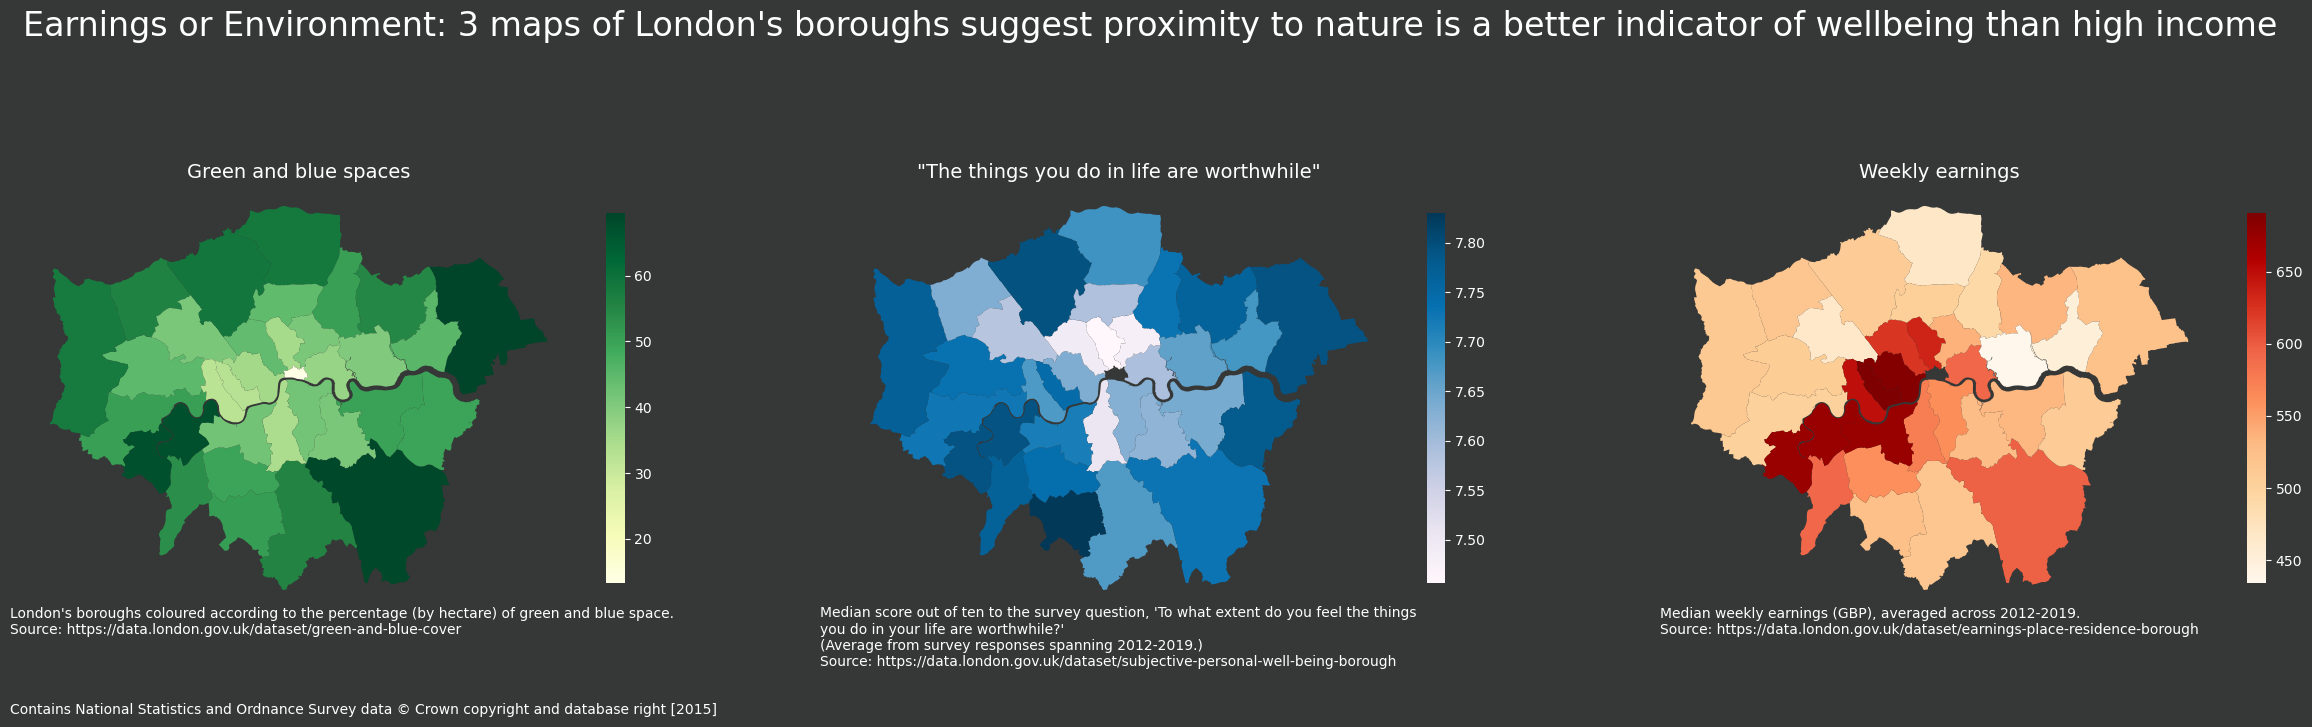

In [15]:
fig,axs=plt.subplots(1,3,figsize=(30,8))

fig.suptitle("Earnings or Environment: 3 maps of London's boroughs suggest proximity to nature is a better indicator of wellbeing than high income", fontsize=24, c='white')#, loc='left')
fig.patch.set_facecolor('xkcd:dark grey')
targets = ['percent_green+blue', 'worthwhile', 'weekly_earnings']
cmaps = ['YlGn', 'PuBu', 'OrRd']
titles = ['Green and blue spaces', '"The things you do in life are worthwhile"', 'Weekly earnings']


for col in range(3):

    ax = axs[col]
    ax.set_title(titles[col], fontsize=14, c='white')

    my_map = merged.plot(column=targets[col], cmap=cmaps[col],ax=ax)
    vmin,vmax=merged[targets[col]].min(),merged[targets[col]].max()
    sm = plt.cm.ScalarMappable(cmap=cmaps[col], norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # Create colourbar
    cbar = fig.colorbar(sm, ax=ax, shrink=0.6)
    cbar.outline.set_visible(False)
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(cbar.ax.get_yticklabels(), color='white')
    
    ax.axis('off')
    
fig.text(0.12,0.2,"London's boroughs coloured according to the percentage (by hectare) of green and blue space.\nSource: https://data.london.gov.uk/dataset/green-and-blue-cover", c='white')
fig.text(0.39,0.16,"Median score out of ten to the survey question, 'To what extent do you feel the things \nyou do in your life are worthwhile?' \n(Average from survey responses spanning 2012-2019.)\nSource: https://data.london.gov.uk/dataset/subjective-personal-well-being-borough", c='white')
fig.text(0.67,0.2,"Median weekly earnings (GBP), averaged across 2012-2019.\nSource: https://data.london.gov.uk/dataset/earnings-place-residence-borough", c='white')
fig.text(0.12, 0.1, "Contains National Statistics and Ordnance Survey data © Crown copyright and database right [2015]", c='white');

#plt.savefig('Earnings or Environment.png', transparent=False);

To further the analysis, I explore several views on the anxiety data, comparing these to the other three maps. There is noticeable similarity between the low anxiety and green and blue space plots, while the high anxiety plot has more kinship with the weekly earnings plot - though this much variation between them and undoubtedly many other contributing factors. It's interesting to note that Richmond features toward the higher end of the anxiety spectrum.

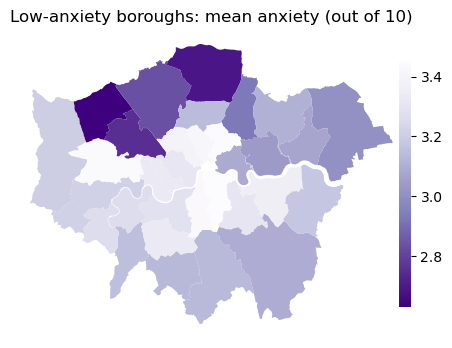

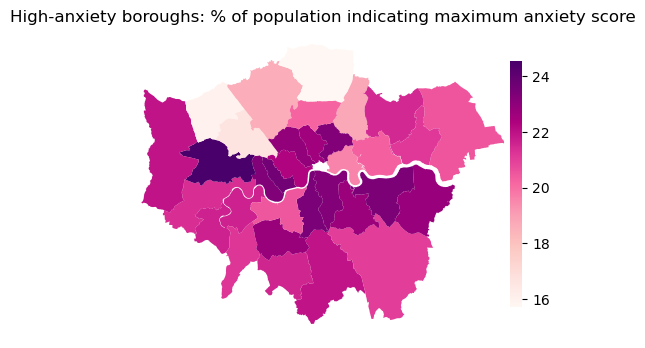

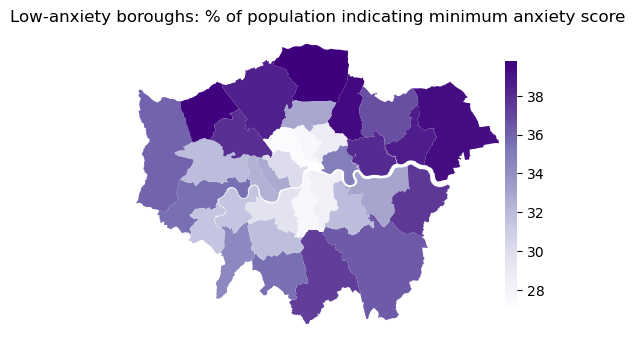

In [17]:
borough_plot(target='anxiety', cmap='Purples_r', title='Low-anxiety boroughs: mean anxiety (out of 10)')
borough_plot('vh_anxiety', 'RdPu', 'High-anxiety boroughs: % of population indicating maximum anxiety score')
borough_plot('l_anxiety', 'Purples', 'Low-anxiety boroughs: % of population indicating minimum anxiety score')

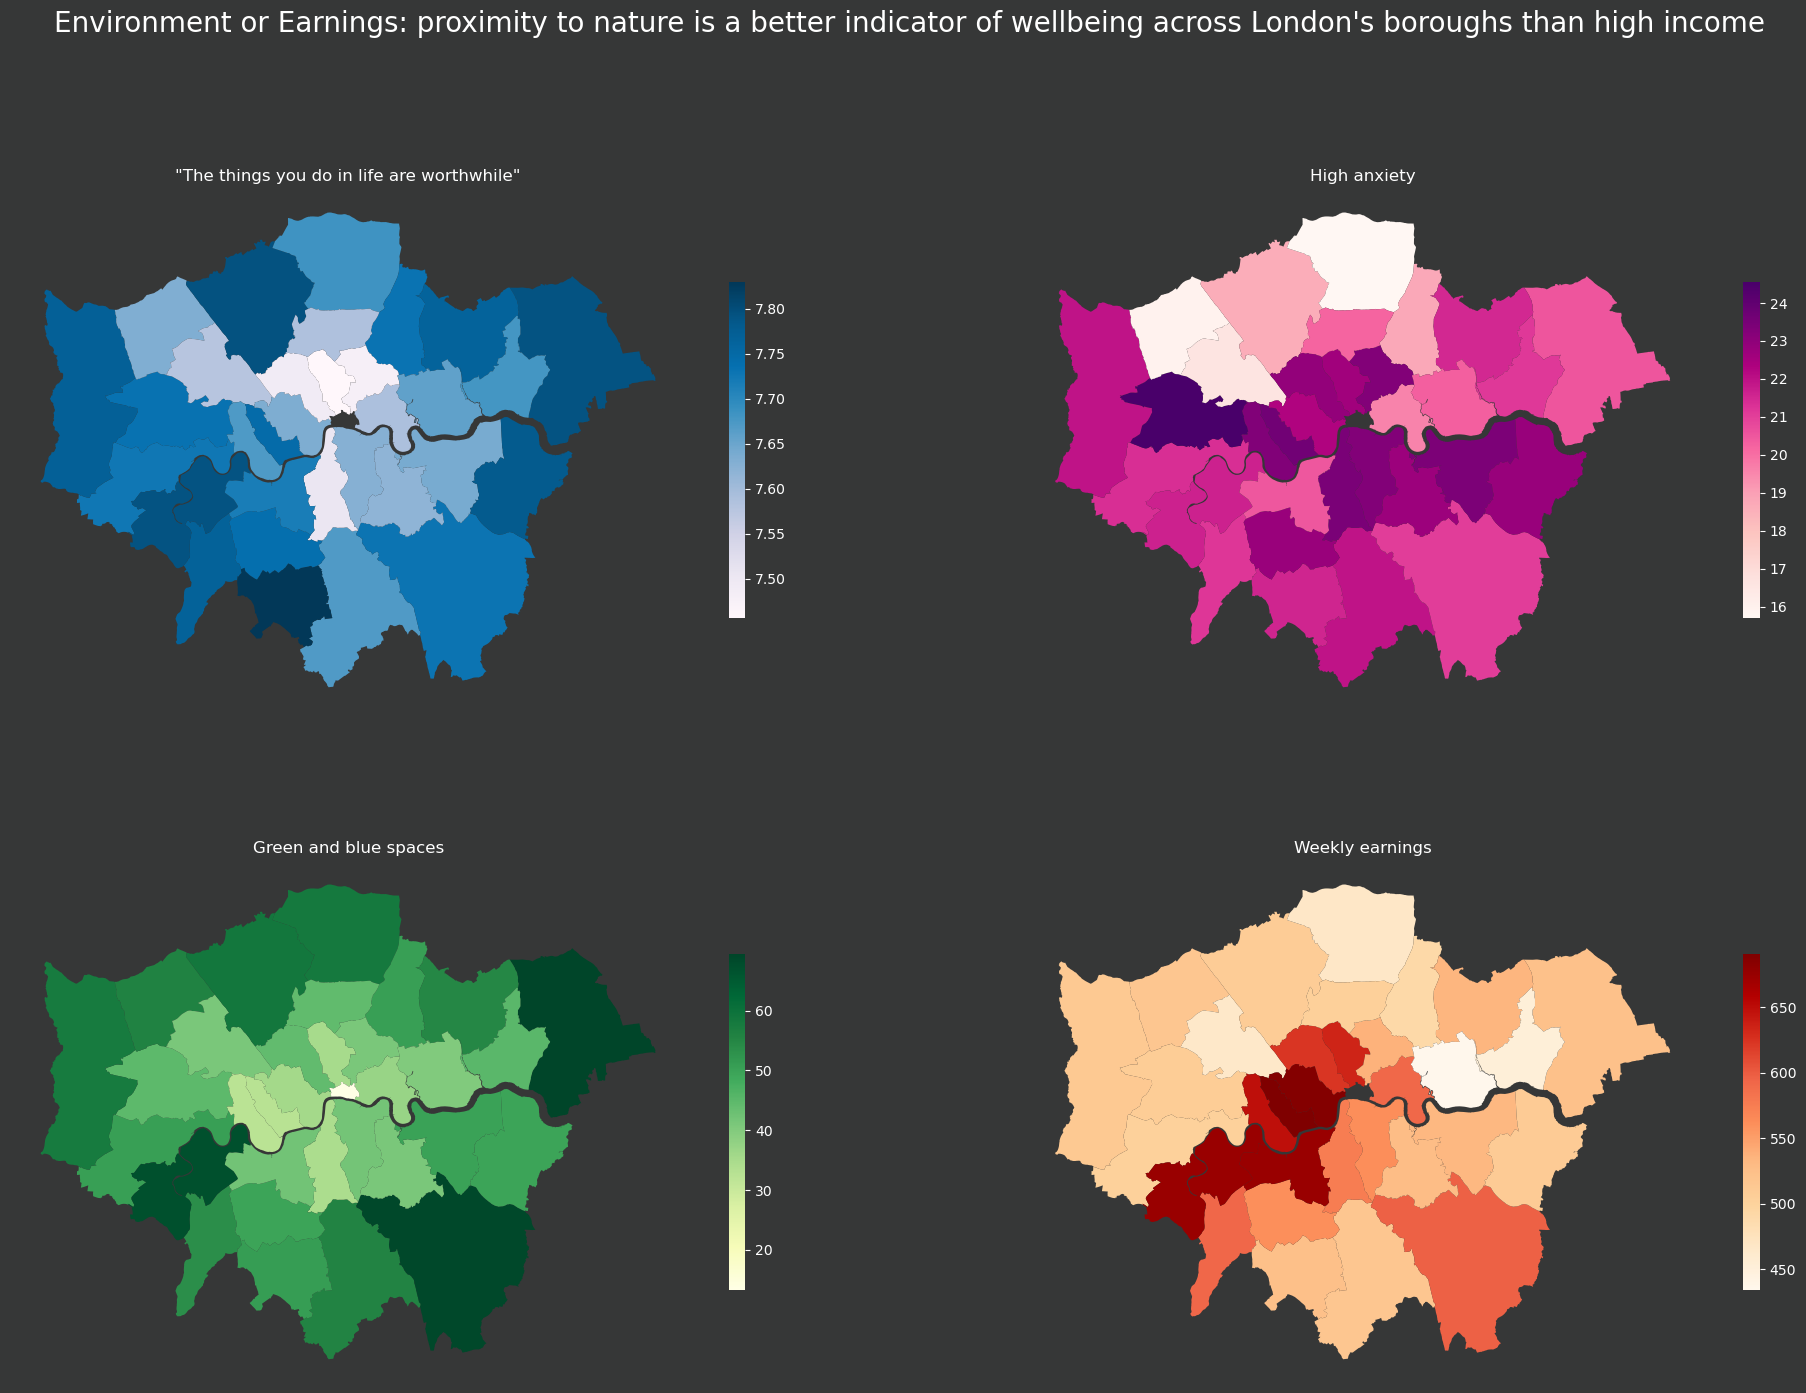

In [18]:
# Plot the geographical spread for worthwhileness, green and blue space density, high anxiety and weekly earnings

fig,axs=plt.subplots(2,2,figsize=(24,16))

fig.suptitle("Environment or Earnings: proximity to nature is a better indicator of wellbeing across London's boroughs than high income", fontsize=20, c='white')
fig.patch.set_facecolor('xkcd:dark grey')
targets = [['worthwhile', 'vh_anxiety'], ['percent_green+blue', 'weekly_earnings']]
cmaps = [['PuBu', 'RdPu'], ['YlGn', 'OrRd']]
titles = [['"The things you do in life are worthwhile"', 'High anxiety'], ['Green and blue spaces', 'Weekly earnings']]
explanations = [["Median score out of ten to the survey question, 'To what extent do you feel the things you do in your life are worthwhile?' \n(Average from survey responses spanning  2011-2019.)",
                 "% of survey respondents in borough that indicated a score of 9-10 (very high) in response to the question, 'How anxious did you feel yesterday? \n(Average from survey responses spanning  2011-2019.)"],
                ["London's boroughs coloured according to the percentage (by hectare) of green and blue space", 
                 "Median weekly earnings (GBP), averaged across 2012-2019"]]

for col in range(2):
    for row in range(2):
        ax = axs[col, row]
        ax.set_title(titles[col][row], c='white')
        
        my_map = merged.plot(column=targets[col][row], cmap=cmaps[col][row],ax=ax)
        vmin,vmax=merged[targets[col][row]].min(),merged[targets[col][row]].max()
        sm = plt.cm.ScalarMappable(cmap=cmaps[col][row], norm=plt.Normalize(vmin=vmin, vmax=vmax))

        cbar = fig.colorbar(sm, ax=ax, shrink=0.6)
        cbar.outline.set_visible(False)
        cbar.ax.yaxis.set_tick_params(color='white')
        plt.setp(cbar.ax.get_yticklabels(), color='white')
       
        ax.axis('off')



### Correlations between wellbeing metrics, earnings and environment
The following matrix presents the correlations between the various metrics we have explored. As expected, life satisfaction, worthwhileness and happiness correlate strongly; low anxiety also correlates with this trio, though more weakly. The % of green and blue space also has a reasonably high correlation with worthwhileness (0.6), and with low anxiety (0.54), happiness (0.47) and life satisfaction (0.42). By contrast, weekly earnings has a small negative correlation with green and blue space access (-0.26), happiness (-0.1) and worthwhileness (-0.09) and only a low positive correlation with life satisfaction (0.23). By contrast, weekly earnings has a moderately high correlation with anxiety (0.53) and a higher still negative correlation with low anxiety (-0.65).

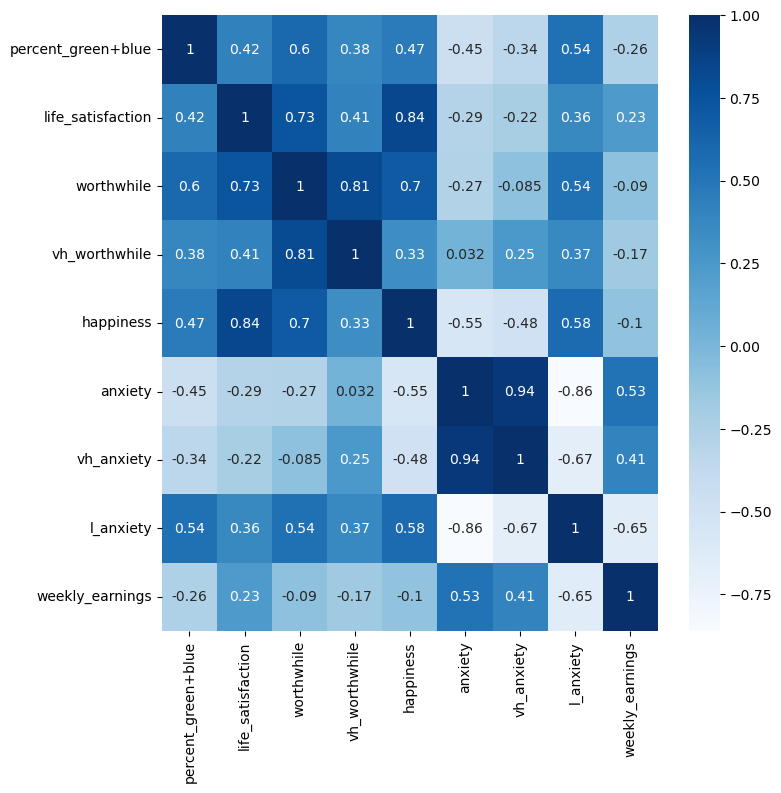

In [20]:
import seaborn as sb

corr = merged[['percent_green+blue', 'life_satisfaction', 'worthwhile', 'vh_worthwhile',
       'happiness', 'anxiety', 'vh_anxiety', 'l_anxiety', 'weekly_earnings']].corr()

fig, ax = plt.subplots(figsize=(8,8))  
sb.heatmap(corr, cmap="Blues", annot=True);


I hope you've enjoyed this exploration of the relationship between wellbeing, nature and earnings across London's boroughs.